# Earthquake Damage Prediction

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# read the dataset
df = pd.read_csv('../DB/EQ_Damage.csv')

C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (37,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis

In [3]:
# list the columns in the dataset
(df.columns)

Index(['district_id', 'vdcmun_id', 'ward_id', 'building_id', 'damage_grade',
       'technical_solution_proposed', 'damage_overall_collapse',
       'damage_overall_leaning', 'damage_overall_adjacent_building_risk',
       'damage_foundation_severe',
       ...
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'vdcmun_name', 'district_name'],
      dtype='object', length=119)

In [4]:
# select the relevent variables
rel_df=df[[
 'district_id',
 'vdcmun_id',
 'damage_grade',
 'count_floors_pre_eq',  
 'age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other', 
 'condition_post_eq',
 'has_geotechnical_risk'
         ]]

C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_building', ylabel='Density'>

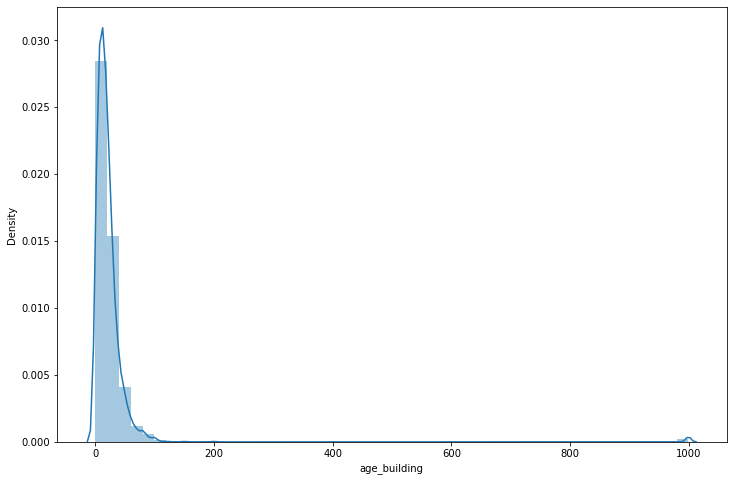

In [5]:
# look into the variables distribution
plt.figure(figsize=(12,8))
sns.distplot(rel_df['age_building'])

In [6]:
count=rel_df['age_building'].value_counts()
print(count.sort_index().to_string())
print(count.sum())

0.0       4732
1.0      19385
2.0      21643
3.0      24431
4.0      23404
5.0      29170
6.0      20113
7.0      23383
8.0      22837
9.0      15151
10.0     39794
11.0     11516
12.0     36458
13.0     15765
14.0     17402
15.0     49983
16.0     16527
17.0     14157
18.0     19643
19.0      7341
20.0     46525
21.0      8204
22.0     22615
23.0      6943
24.0      7943
25.0     37063
26.0      8834
27.0      9961
28.0      7669
29.0      2929
30.0     30826
31.0      2835
32.0      9430
33.0      2629
34.0      2551
35.0     16869
36.0      3985
37.0      3012
38.0      2429
39.0      1069
40.0     19666
41.0      1092
42.0      3675
43.0      1060
44.0      1558
45.0      7336
46.0      1092
47.0      1061
48.0      1509
49.0       495
50.0     14750
51.0       653
52.0      1555
53.0       497
54.0       901
55.0      3034
56.0       629
57.0       631
58.0       575
59.0       362
60.0      7178
61.0       422
62.0       608
63.0       294
64.0       269
65.0      1812
66.0      

In [7]:
# defining bins for the building age
bins=[-1,10,25,50,1000]
labels=["new","almost_new","old","very_old"]
rel_df["age_binned"]=pd.cut(rel_df['age_building'], bins=bins,labels=labels)

C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
count=rel_df["age_binned"].value_counts()
print(count.sort_index().to_string())
print(count.sum())

new           244043
almost_new    318085
old           158322
very_old       41656
762106


In [9]:
rel_df=rel_df.drop(columns=['age_building'])

In [10]:
# check for null cells
rel_df.isnull().sum()

district_id                                0
vdcmun_id                                  0
damage_grade                              28
count_floors_pre_eq                       16
plinth_area_sq_ft                         16
height_ft_pre_eq                          16
land_surface_condition                    16
foundation_type                           16
roof_type                                 16
ground_floor_type                         16
other_floor_type                          16
position                                  17
plan_configuration                        17
has_superstructure_adobe_mud              16
has_superstructure_mud_mortar_stone       16
has_superstructure_stone_flag             16
has_superstructure_cement_mortar_stone    16
has_superstructure_mud_mortar_brick       16
has_superstructure_cement_mortar_brick    16
has_superstructure_timber                 16
has_superstructure_bamboo                 16
has_superstructure_rc_non_engineered      16
has_supers

In [11]:
rel_df=rel_df.dropna()

In [12]:
rel_df.dtypes

district_id                                  int64
vdcmun_id                                    int64
damage_grade                                object
count_floors_pre_eq                        float64
plinth_area_sq_ft                          float64
height_ft_pre_eq                           float64
land_surface_condition                      object
foundation_type                             object
roof_type                                   object
ground_floor_type                           object
other_floor_type                            object
position                                    object
plan_configuration                          object
has_superstructure_adobe_mud               float64
has_superstructure_mud_mortar_stone        float64
has_superstructure_stone_flag              float64
has_superstructure_cement_mortar_stone     float64
has_superstructure_mud_mortar_brick        float64
has_superstructure_cement_mortar_brick     float64
has_superstructure_timber      

In [13]:
damage_grade_updated = rel_df['damage_grade'].replace(to_replace ='Grade ', value='',regex = True )
rel_df['damage_grade']=damage_grade_updated

In [14]:
# convert non-continues variables to object
rel_df['damage_grade'] = rel_df['damage_grade'].astype(float)
rel_df['district_id'] = rel_df['district_id'].astype(object)
rel_df['vdcmun_id'] = rel_df['vdcmun_id'].astype(object)
rel_df.dtypes

district_id                                 object
vdcmun_id                                   object
damage_grade                               float64
count_floors_pre_eq                        float64
plinth_area_sq_ft                          float64
height_ft_pre_eq                           float64
land_surface_condition                      object
foundation_type                             object
roof_type                                   object
ground_floor_type                           object
other_floor_type                            object
position                                    object
plan_configuration                          object
has_superstructure_adobe_mud               float64
has_superstructure_mud_mortar_stone        float64
has_superstructure_stone_flag              float64
has_superstructure_cement_mortar_stone     float64
has_superstructure_mud_mortar_brick        float64
has_superstructure_cement_mortar_brick     float64
has_superstructure_timber      

In [15]:
# Generate categorical variable lists
data_cat = rel_df.dtypes[rel_df.dtypes == "object"].index.tolist()
data_cat

['district_id',
 'vdcmun_id',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'condition_post_eq']

In [16]:
# add age_binned to teh list of categorial variables
data_cat.append("age_binned")

In [17]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(rel_df[data_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(data_cat)
encode_df.head()

C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,district_id_12,district_id_20,district_id_21,district_id_22,district_id_23,district_id_24,district_id_28,district_id_29,district_id_30,district_id_31,...,condition_post_eq_Damaged-Repaired and used,condition_post_eq_Damaged-Rubble Clear-New building built,condition_post_eq_Damaged-Rubble clear,condition_post_eq_Damaged-Rubble unclear,condition_post_eq_Damaged-Used in risk,condition_post_eq_Not damaged,age_binned_almost_new,age_binned_new,age_binned_old,age_binned_very_old
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [18]:
# Merge one-hot encoded features and drop the originals
rel_m_df = rel_df.merge(encode_df,left_index=True, right_index=True)
rel_m_df = rel_m_df.drop(data_cat,1)
rel_m_df.head()

C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,damage_grade,count_floors_pre_eq,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,condition_post_eq_Damaged-Repaired and used,condition_post_eq_Damaged-Rubble Clear-New building built,condition_post_eq_Damaged-Rubble clear,condition_post_eq_Damaged-Rubble unclear,condition_post_eq_Damaged-Used in risk,condition_post_eq_Not damaged,age_binned_almost_new,age_binned_new,age_binned_old,age_binned_very_old
0,4.0,2.0,356.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.0,2.0,275.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.0,2.0,450.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.0,2.0,240.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.0,2.0,300.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
# Split our preprocessed data into our features and target arrays
yy = rel_m_df.damage_grade
X = rel_m_df.drop(columns=["damage_grade"])

In [20]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, yy, random_state=78)

In [21]:
# oversampling algorithm
oversample = SMOTE(random_state=78)
X_train_resamp, y_train_resamp = oversample.fit_resample(X_train, y_train)

In [22]:
y_train_resamp.value_counts()

3.0    206792
2.0    206792
5.0    206792
4.0    206792
1.0    206792
Name: damage_grade, dtype: int64

# Regression Model

In [23]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train_resamp)

# Scale the data
X_train_resamp_scaled = X_scaler.transform(X_train_resamp)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
# define the multinomial logistic regression model
model_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model
model_LR.fit(X_train_resamp_scaled, y_train_resamp)

# Predict 
predictions_LR = model_LR.predict(X_test_scaled)

In [39]:
model_LR.score(X_test_scaled, y_test)

0.5864852664840068

In [33]:
# performance of the model
print(metrics.classification_report(y_test,predictions_LR))

              precision    recall  f1-score   support

         1.0       0.54      0.62      0.58     19582
         2.0       0.33      0.62      0.43     21997
         3.0       0.35      0.14      0.20     34084
         4.0       0.59      0.74      0.66     45881
         5.0       0.84      0.69      0.76     68974

    accuracy                           0.59    190518
   macro avg       0.53      0.56      0.52    190518
weighted avg       0.60      0.59      0.58    190518



# Balanced Random Forest Classifier

In [34]:
y_train_final= pd.get_dummies(y_train_resamp)
y_test_final= pd.get_dummies(y_test)

In [35]:
y_train_final=y_train_final.values
y_test_final=y_test_final.values

In [36]:
X_train_final=X_train_resamp.values
X_test_final=X_test.values

In [37]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train_final)

# Scale the data
X_train_scaled = X_scaler.transform(X_train_final)
X_test_scaled = X_scaler.transform(X_test_final)

In [38]:
# Define the model
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)

# fit the model
brf_model = brf_model.fit(X_train_scaled, y_train_final)

# Predict 
predictions = brf_model.predict(X_test_scaled)

In [43]:
brf_model.score(X_test_scaled, y_test_final)

0.49814715669910453

In [44]:
# performance of the model
print(classification_report(y_test_final,predictions))

              precision    recall  f1-score   support

           0       0.71      0.48      0.57     19582
           1       0.50      0.25      0.33     21997
           2       0.38      0.14      0.20     34084
           3       0.65      0.57      0.61     45881
           4       0.81      0.71      0.76     68974

   micro avg       0.69      0.50      0.58    190518
   macro avg       0.61      0.43      0.49    190518
weighted avg       0.65      0.50      0.55    190518
 samples avg       0.50      0.50      0.50    190518



C:\Users\italebinejad\Anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Nueral Network Model

In [45]:
# define the model
NN_model = Sequential()
NN_model.add(Dense(120, input_dim = len(X_train_scaled[0]), activation = 'relu')) 
NN_model.add(Dense(120, activation = 'relu'))
NN_model.add(Dense(5, activation = 'sigmoid')) 
NN_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

# fit the model
fit_model=NN_model.fit(X_train_scaled,y_train_final, epochs=100)

# predict
NN_predictions = NN_model.predict(X_test_scaled)

Epoch 1/100
32312/32312 [==============================] - 61s 2ms/step - loss: 0.9670 - categorical_accuracy: 0.6071
Epoch 2/100
32312/32312 [==============================] - 61s 2ms/step - loss: 0.9184 - categorical_accuracy: 0.6274
Epoch 3/100
32312/32312 [==============================] - 62s 2ms/step - loss: 0.9018 - categorical_accuracy: 0.6337
Epoch 4/100
32312/32312 [==============================] - 59s 2ms/step - loss: 0.8917 - categorical_accuracy: 0.6381
Epoch 5/100
32312/32312 [==============================] - 67s 2ms/step - loss: 0.8854 - categorical_accuracy: 0.6407
Epoch 6/100
32312/32312 [==============================] - 68s 2ms/step - loss: 0.8802 - categorical_accuracy: 0.6427
Epoch 7/100
32312/32312 [==============================] - 69s 2ms/step - loss: 0.8768 - categorical_accuracy: 0.6445
Epoch 8/100
32312/32312 [==============================] - 69s 2ms/step - loss: 0.8733 - categorical_accuracy: 0.6460
Epoch 9/100
32312/32312 [==============================]

32312/32312 [==============================] - 72s 2ms/step - loss: 0.8556 - categorical_accuracy: 0.6550
Epoch 70/100
32312/32312 [==============================] - 70s 2ms/step - loss: 0.8566 - categorical_accuracy: 0.6546
Epoch 71/100
32312/32312 [==============================] - 68s 2ms/step - loss: 0.8573 - categorical_accuracy: 0.6545
Epoch 72/100
32312/32312 [==============================] - 68s 2ms/step - loss: 0.8576 - categorical_accuracy: 0.6543
Epoch 73/100
32312/32312 [==============================] - 69s 2ms/step - loss: 0.8568 - categorical_accuracy: 0.6542
Epoch 74/100
32312/32312 [==============================] - 68s 2ms/step - loss: 0.8566 - categorical_accuracy: 0.6543
Epoch 75/100
32312/32312 [==============================] - 57s 2ms/step - loss: 0.8569 - categorical_accuracy: 0.6544
Epoch 76/100
32312/32312 [==============================] - 57s 2ms/step - loss: 0.8578 - categorical_accuracy: 0.6539
Epoch 77/100
32312/32312 [==============================] - 5

In [47]:
# performance of the model
y_p=np.argmax(NN_predictions, axis=1)
y_t=np.argmax(y_test_final, axis=1)
print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       0.53      0.65      0.58     19582
           1       0.47      0.38      0.42     21997
           2       0.35      0.23      0.28     34084
           3       0.58      0.80      0.67     45881
           4       0.80      0.72      0.76     68974

    accuracy                           0.61    190518
   macro avg       0.55      0.56      0.54    190518
weighted avg       0.60      0.61      0.60    190518

